In [7]:
import sys, os
import numpy as np
from matplotlib import pyplot as plt
from halotools import sim_manager
import h5py
from scipy import stats
from scipy import fftpack
from scipy.fftpack import fftfreq, fftshift, ifftshift, ifftn

/u/ayannam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
Lbox = 512.0 # size of box in Mpc/h
Ngrid = 256.0 # number of cells in 1D of grid for power spectrum
bin_centers = np.arange(Ngrid) # integer linear space up to number of cells for as bin centers
Lgrid = Lbox / Ngrid # the size of each individual grid cell

In [84]:
def separate(neutrino_mass, redshift, num_bins, tag = "mass"):
    
    PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_PID.npy")
    parents_mask = PID == -1
    # load the data
    mass = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_mass.npy")
    mass = mass[parents_mask]
    mass_order = stats.rankdata(mass, method = "max")
    mass_normed = mass_order / np.max(mass_order)
    if tag == "mass":
        return mass, mass, np.array(mass_normed)
    
    bin_edges = np.linspace(np.min(mass), np.max(mass), num_bins + 1)
    
    if tag == "concentration":
        con = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_con.npy")
        con = con[parents_mask]
        con_normed = np.zeros(len(con))
        count = 0
        for b in bin_edges[1:]:
            upper_mask = mass >= bin_edges[count]
            lower_mask = mass <  b
            mask = upper_mask & lower_mask
            con_order = stats.rankdata(con[mask], method = "max")
            if len(con_order) != 0:
                con_normed[mask] = con_order / np.max(con_order)
            count = count + 1
        return mass, con, np.array(con_normed)
    elif tag == "vmax":
        vmax = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_vmax.npy")
        vmax = vmax[parents_mask]
        vmax_normed = np.zeros(len(vmax))
        count = 0
        for b in bin_edges[1:]:
            upper_mask = mass >= bin_edges[count]
            lower_mask = mass <  b
            mask = upper_mask & lower_mask
            vmax_order = stats.rankdata(vmax[mask], method = "max")
            if len(vmax_order) != 0:
                vmax_normed[mask] = vmax_order / np.max(vmax_order)
            count = count + 1
        return mass, vmax, np.array(vmax_normed)
    elif tag == "spin":
        spin = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_spin.npy")
        spin = spin[parents_mask]
        spin_normed = np.zeros(len(spin))
        count = 0
        for b in bin_edges[1:]:
            upper_mask = mass >= bin_edges[count]
            lower_mask = mass <  b
            mask = upper_mask & lower_mask
            spin_order = stats.rankdata(spin[mask], method = "max")
            if len(spin_order) != 0:
                spin_normed[mask] = spin_order / np.max(spin_order)
            count = count + 1
        return mass, spin, np.array(spin_normed)
    else:
        return "Invalid Tag"

In [109]:
def gridding(halo_positions):
    # returns a 3D grid of the density of halos
    grid = np.histogramdd(halo_positions / Lgrid, bins = [bin_centers, bin_centers, bin_centers])[0]
    grid = grid / np.mean(grid) - 1
    return grid

def azimuthalAverage3D(grid, edges = None, logbins = True, bins = 50):
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
     
    if grid.shape[0]%2 == 0:
        center+=0.5
     
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)#distance to center pixel, for each pixel
 
    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # the index to sort by r
    i_sorted = grid.flat[ind] # the index of the images sorted by r
 
    # find index that's corresponding to the lower edge of each bin
    kmin=1.0
    kmax=grid.shape[0]/2.0
    if edges == None:
        if logbins:
            edges = np.logspace(np.log10(kmin),np.log10(kmax),bins+1)
        else:
            #edges = linspace(kmin,kmax+0.001,bins+1)    
            edges = np.linspace(kmin,kmax,bins+1)
    if edges[0] > 0:
        edges = np.append([0],edges)
         
    hist_ind = np.histogram(r_sorted,bins = edges)[0] # hist_ind: the number in each ell bins, sum them up is the index of lower edge of each bin, first bin spans from 0 to left of first bin edge.    
    hist_sum = np.cumsum(hist_ind)
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[hist_sum[1:]] - csim[hist_sum[:-1]]
    radial_prof = tbin / hist_ind[1:]
    return edges[1:], radial_prof

edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])

def PowerSpectrum3D(grid, logbins = True, bins=50):
    # Calculate the power spectrum for a cube.
    # Input:
    # grid = input grid in numpy array.
    # Output:
    # k, psd1D
    isize = grid.shape[0]
    F = fftshift(fftpack.fftn(grid))
    psd3D = np.abs(F)**2
    k_arr, psd1D = azimuthalAverage3D(psd3D, logbins = logbins, bins=bins)
    k_arr = edge2center(k_arr)
    return k_arr, psd1D
 
def process_ps(igrid):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    k, ps3d = PowerSpectrum3D(igrid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed

In [105]:
def get_bias(neutrino_mass, redshift, num_bins, p_lower, p_upper, tag = "mass"):
    
    mass, tag, tag_normed = separate(neutrino_mass, redshift, num_bins, tag)
    #mass_upper_mask = mass <= m_binupper
    #mass_lower_mask = mass > m_binlower
    mass_mask = mass > 0
    PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_PID.npy")
    parents_mask = PID == -1
    use_mask = mass_mask #& parents_mask
    
    pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_pos.npy")
    pos = pos[parents_mask]
    pos = pos[use_mask]
    
    tag = tag[use_mask]
    tag_normed = tag_normed[use_mask]
    
    tag_upper_mask = tag_normed >= p_upper
    tag_lower_mask = tag_normed <= p_lower

    pos_upper = pos[tag_upper_mask]
    pos_lower = pos[tag_lower_mask]
    
    particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_" + str(neutrino_mass) + "/snapshot_0" + str(redshift) + ".npy")
    particle_grid = gridding(particles)
    
    phh_upper_grid = gridding(pos_upper)
    phh_lower_grid = gridding(pos_lower)
    phh_grid = gridding(pos)

    khu, phu = process_ps(phh_upper_grid)
    khl, phl = process_ps(phh_lower_grid)
    kh, ph = process_ps(phh_grid)
    kp, pp = process_ps(particle_grid)
    
    return kh, khu, khl, ph, phu, phl, pp

In [113]:
def get_bias_mass_bins(neutrino_mass, redshift, num_bins, p_lower, p_upper, m_binlower, m_binupper, tag = "mass"):
    
    mass, tag, tag_normed = separate(neutrino_mass, redshift, num_bins, tag)
    mass_upper_mask = mass <= m_binupper
    mass_lower_mask = mass > m_binlower
    PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_PID.npy")
    parents_mask = PID == -1
    use_mask = mass_upper_mask & mass_lower_mask #& parents_mask
    
    pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_pos.npy")
    pos = pos[parents_mask]
    pos = pos[use_mask]
    
    tag = tag[use_mask]
    tag_normed = tag_normed[use_mask]
    
    tag_upper_mask = tag_normed >= p_lower
    tag_lower_mask = tag_normed <= p_upper
    tag_mask = tag_upper_mask & tag_lower_mask

    pos_per = pos[tag_mask]
    
    particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_" + str(neutrino_mass) + "/snapshot_0" + str(redshift) + ".npy")
    particle_grid = gridding(particles)
    
    phh_per_grid = gridding(pos_per)
    phh_grid = gridding(pos)

    khp, php = process_ps(phh_per_grid)
    kh, ph = process_ps(phh_grid)
    kp, pp = process_ps(particle_grid)
    
    return kh, khp, ph, php, pp

In [117]:
def get_bias_percent_bins(neutrino_mass, redshift, num_bins, p_lower, p_upper, tag = "mass"):
    
    mass, tag, tag_normed = separate(neutrino_mass, redshift, num_bins, tag)
    #mass_upper_mask = mass <= m_binupper
    #mass_lower_mask = mass > m_binlower
    mass_mask = mass > 0
    PID = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_PID.npy")
    parents_mask = PID == -1
    use_mask = mass_mask #& parents_mask
    
    pos = np.load("/u/ayannam/Documents/Raw_Data/mnv_" + str(neutrino_mass) + "/out_" + str(redshift) + "_parents_pos.npy")
    pos = pos[parents_mask]
    pos = pos[use_mask]
    
    tag = tag[use_mask]
    tag_normed = tag_normed[use_mask]
    
    tag_upper_mask = tag_normed >= p_lower
    tag_lower_mask = tag_normed <= p_upper
    tag_mask = tag_upper_mask & tag_lower_mask

    pos_upper = pos[tag_upper_mask]
    pos_lower = pos[tag_lower_mask]
    
    particles = np.load("/u/ayannam/Documents/Raw_Data/snapshot_mnv_" + str(neutrino_mass) + "/snapshot_0" + str(redshift) + ".npy")
    particle_grid = gridding(particles)
    
    phh_upper_grid = gridding(pos_upper)
    phh_lower_grid = gridding(pos_lower)
    phh_grid = gridding(pos)

    khu, phu = process_ps(phh_upper_grid)
    khl, phl = process_ps(phh_lower_grid)
    kh, ph = process_ps(phh_grid)
    kp, pp = process_ps(particle_grid)
    
    return kh, khu, khl, ph, phu, phl, pp

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


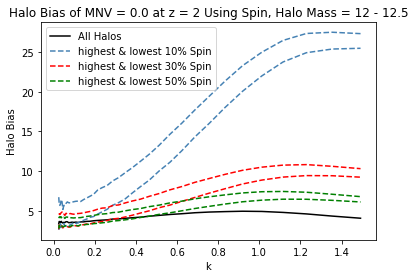

In [115]:
kh, khu, khl, ph, phu, phl, pp = get_bias(0.0, 37, 100, 0.1, 0.9, "spin")

plt.plot(kh, ph / pp, color = "black", label = "All Halos")
plt.plot(khu, phu / pp, color = "steelblue", linestyle = "dashed", label = "highest & lowest 10% Spin")
plt.plot(khl, phl / pp, color = "steelblue", linestyle = "dashed")

kh, khu, khl, ph, phu, phl, pp = get_bias(0.0, 37, 100, 0.3, 0.7, "spin")

#plt.plot(kh, ph / pp, color = "r", label = "mass = 14 - 14.1 30%")
plt.plot(khu, phu / pp, color = "r", linestyle = "dashed", label = "highest & lowest 30% Spin")
plt.plot(khl, phl / pp, color = "r", linestyle = "dashed")

kh, khu, khl, ph, phu, phl, pp = get_bias(0.0, 37, 100, 0.5, 0.5, "spin")

#plt.plot(kh, ph / pp, color = "g", label = "mass = 14 - 14.1 50%")
plt.plot(khu, phu / pp, color = "g", linestyle = "dashed", label = "highest & lowest 50% Spin")
plt.plot(khl, phl / pp, color = "g", linestyle = "dashed")

plt.title("Halo Bias of MNV = 0.0 at z = 2 Using Spin, Halo Mass = 12 - 12.5")
plt.xlabel("k")
plt.ylabel("Halo Bias")
plt.legend()
plt.show()



/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


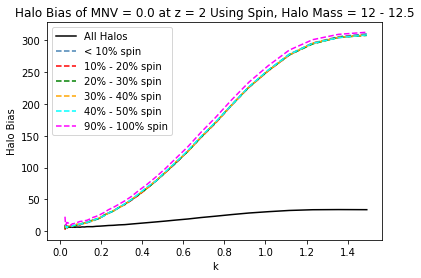

In [114]:
kh, khp, ph, php, pp = get_bias_mass_bins(0.0, 37, 100, 0, 0.1, 12, 12.5, "spin")

plt.plot(kh, ph / pp, color = "black", label = "All Halos")
plt.plot(khp, php / pp, color = "steelblue", linestyle = "dashed", label = "< 10% spin")

kh, khp, ph, php, pp = get_bias_mass_bins(0.0, 37, 100, 0.1, 0.2, 12, 12.5, "spin")
plt.plot(khp, php / pp, color = "r", linestyle = "dashed", label = "10% - 20% spin")

kh, khp, ph, php, pp = get_bias_mass_bins(0.0, 37, 100, 0.2, 0.3, 12, 12.5, "spin")
plt.plot(khp, php / pp, color = "g", linestyle = "dashed", label = "20% - 30% spin")

kh, khp, ph, php, pp = get_bias_mass_bins(0.0, 37, 100, 0.3, 0.4, 12, 12.5, "spin")
plt.plot(khp, php / pp, color = "orange", linestyle = "dashed", label = "30% - 40% spin")

kh, khp, ph, php, pp = get_bias_mass_bins(0.0, 37, 100, 0.4, 0.5, 12, 12.5, "spin")
plt.plot(khp, php / pp, color = "cyan", linestyle = "dashed", label = "40% - 50% spin")

kh, khp, ph, php, pp = get_bias_mass_bins(0.0, 37, 100, 0.9, 1, 12, 12.5, "spin")
plt.plot(khp, php / pp, color = "magenta", linestyle = "dashed", label = "90% - 100% spin")

plt.title("Halo Bias of MNV = 0.0 at z = 2 Using Spin, Halo Mass = 12 - 12.5")
plt.xlabel("k")
plt.ylabel("Halo Bias")
plt.legend()
plt.show()

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


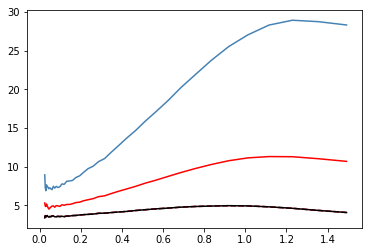

In [119]:
kh, khu, khl, ph, phu, phl, pp = get_bias_percent_bins(0.0, 37, 100, 0, 0.1, "mass")
plt.plot(khu, phu / pp, color = "steelblue", linestyle = "dashed", label = "highest & lowest 10%")

kh, khu, khl, ph, phu, phl, pp = get_bias_percent_bins(0.0, 37, 100, 0.9, 1, "mass")
plt.plot(khu, phu / pp, color = "steelblue")

kh, khu, khl, ph, phu, phl, pp = get_bias_percent_bins(0.0, 37, 100, 0, 0.3, "mass")
plt.plot(khu, phu / pp, color = "r", linestyle = "dashed", label = "highest & lowest 30%")

kh, khu, khl, ph, phu, phl, pp = get_bias_percent_bins(0.0, 37, 100, 0.7, 1, "mass")
plt.plot(khu, phu / pp, color = "r")

plt.plot(kh, ph / pp, color = "black", label = "All Halos")
plt.show()